# U.S. Patent Phrase to Phrase Matching
* [Data](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data?select=train.csv)
   - Don Cenkci, Grigor Aslanyan, Ian Wetherbee, jm, Kiran Gunda, Maggie, Scott Beliveau, Will Cukierski. (2022). U.S. Patent Phrase to Phrase Matching. Kaggle. 
 
## Problem Statement and Objective
The objective is to predict the Pearson similarity score, a number between 0 and 1, between phrases extracted from US Patents.
This is a regression problem.
The data also includes the context in which the phrases are to be understood: the first two levels of the [CPC Classification](https://en.wikipedia.org/wiki/Cooperative_Patent_Classification).

## Methodology
Clean up the data, then convert to numerical values, then train a suitable ML model.
Not too much cleaning seems to be required on the phrases themselves, they are already converted to lower case,
don't seem to have contractions, etc.  Will apply some cleanup just in case, but does not seem to be strictly necessary.
We will however remove "stop" words.

Next, we need to convert the phrases into numerical form.   We will convert each phrase into a vector representing
the meanings in the sentences.  The phrases are quite short generally, just a few words, so need to pick an approach suitable 
for that kind of data.

The other issue is the CPC category.   There are a lot of CPC categories, but we decided to use a one-hot encoding regardless.
We did not try to break the categories into primary and secondary categories however to avoid spurious matches based on similar
secondary categories with different primary categories.  That is, we don't want A45 and B45 to be treated as similar because the
meaning of "45" is completely different in the A and B primary categories.

For the ML model training, we will try a set of different models and use hyperparameter training to try and find the best
approach.   The best models on the leaderboard seem to have accuracies in the 80% to 90% range.

As a note the training data seems to have scores drawn from a small set of possible values: 0, 0.25, 0.5, 0.75, and 1, but this is likely
just an artifact of manual scoring, and we will assume continuous scores in the range 0 to 1 inclusive are acceptable.

## Libraries

In [1]:
# Only need to run these once
# !python -m pip install tqdm
# !python -m spacy download en_core_web_lg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import max_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tqdm import tqdm

The following defines a function that uses the SpaCy `en_core_web_lg` model it to compute a vector
representing all the words in a document.   The "documents" here will be single phrases.

In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return np.array(vec)

/home/mmccool/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

| Label       | Meaning                       | Values                                                                                  |
| ----------- | ----------------------------- | ----------------------------------------------------------------------------------------|
| id          | unique phrase pair identifier | irrelevant for training                                                                 |
| anchor      |	first phrase                  | string                                                                                  |
| target	  | second phrase                 | string                                                                                  |
| context     | CPC Category                  | just primary and secondary, eg. A45                                                     |
| score	      | training target value         | real number between 0 and 1                                                             |

In [4]:
dataset = pd.read_csv('train.csv')
dataset

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Clean up data and convert to numerical form.

In [5]:
P = dataset.iloc[:, 1:3].values  # pairs of phrases
print(P)

[['abatement' 'abatement of pollution']
 ['abatement' 'act of abating']
 ['abatement' 'active catalyst']
 ...
 ['wood article' 'wooden handle']
 ['wood article' 'wooden material']
 ['wood article' 'wooden substrate']]


In [6]:
# encode strings using word2vec
W = []
for i in range(0,len(P)):
    vec_a = get_vec(P[i,0])
    vec_b = get_vec(P[i,1])
    W.append(np.concatenate([vec_a,vec_b]))
W = np.array(W)
W

array([[-0.38802   , -3.3569    ,  0.64431   , ..., -4.2568336 ,
         0.05521335, -1.6463066 ],
       [-0.38802   , -3.3569    ,  0.64431   , ..., -2.3863666 ,
        -1.80434   , -0.18226679],
       [-0.38802   , -3.3569    ,  0.64431   , ..., -2.06823   ,
        -1.8922999 ,  0.60232   ],
       ...,
       [-3.18225   , -4.74395   , -1.5241499 , ..., -0.66548496,
        -0.08734995, -2.0045    ],
       [-3.18225   , -4.74395   , -1.5241499 , ..., -1.26545   ,
        -1.8422    , -0.29785   ],
       [-3.18225   , -4.74395   , -1.5241499 , ..., -1.43465   ,
        -1.6294999 , -0.29955   ]], dtype=float32)

In [7]:
W.shape

(36473, 600)

In [8]:
dt = dataset.iloc[:,3:4].values
dt

array([['A47'],
       ['A47'],
       ['A47'],
       ...,
       ['B44'],
       ['B44'],
       ['B44']], dtype=object)

In [9]:
ct = ColumnTransformer(transformers=[('encodeContext', OneHotEncoder(sparse_output=False), [0])])
C = ct.fit_transform(dt)
C

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
C.shape

(36473, 106)

In [11]:
X = np.concatenate((W,C), axis=1)
X

array([[-0.38802001, -3.35689998,  0.64431   , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38802001, -3.35689998,  0.64431   , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38802001, -3.35689998,  0.64431   , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.18225002, -4.74394989, -1.52414989, ...,  0.        ,
         0.        ,  0.        ],
       [-3.18225002, -4.74394989, -1.52414989, ...,  0.        ,
         0.        ,  0.        ],
       [-3.18225002, -4.74394989, -1.52414989, ...,  0.        ,
         0.        ,  0.        ]])

In [12]:
X.shape

(36473, 706)

In [13]:
y = dataset.iloc[:,-1].values
y

array([0.5 , 0.75, 0.25, ..., 0.5 , 0.75, 0.5 ])

In [14]:
y.shape

(36473,)

## Train/Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [38]:
X_train.shape

(29178, 706)

In [39]:
y_train.shape

(29178,)

In [49]:
sm_X_train, sm_X_test, sm_y_train, sm_y_test = train_test_split(X, y, test_size = 0.90, random_state = 0)

In [50]:
sm_X_train.shape

(3647, 706)

In [51]:
sm_y_train.shape

(3647,)

## Feature Scaling
Not strictly needed, but some of the word vector elements are outside the range [-1,1], so just to be safe...

In [52]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
sm_sc = StandardScaler()
sm_X_train = sc.fit_transform(sm_X_train)
sm_X_test = sc.transform(sm_X_test)

## LinearSVR

In [53]:
linear_svr = LinearSVR(C = 1, max_iter=1000000, random_state = 0)
linear_svr.fit(sm_X_train, sm_y_train)

LinearSVR(C=1, max_iter=1000000, random_state=0)

### Evaluation
For default values of hyperparameters for SVR.

Compute predictions using model.

In [54]:
y_true = sm_y_test
y_pred = linear_svr.predict(sm_X_test)

Evaluate a set of metrics.

In [55]:
print(f"Max error: {max_error(y_true, y_pred)}")
print(f"RMS error: {root_mean_squared_error(y_true, y_pred)}")
print(f"Mean absolute error: {mean_absolute_error(y_true, y_pred)}")
print(f"R2 score: {r2_score(y_true, y_pred)}")

Max error: 1.5753165572982382
RMS error: 0.283032425805942
Mean absolute error: 0.22446312783859865
R2 score: -0.19710200142482281


Plot visualization of true vs. predicted values.

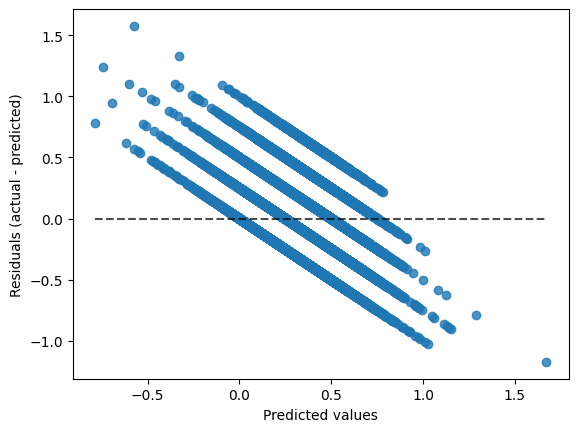

In [56]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
display.plot()

Histogram of errors.

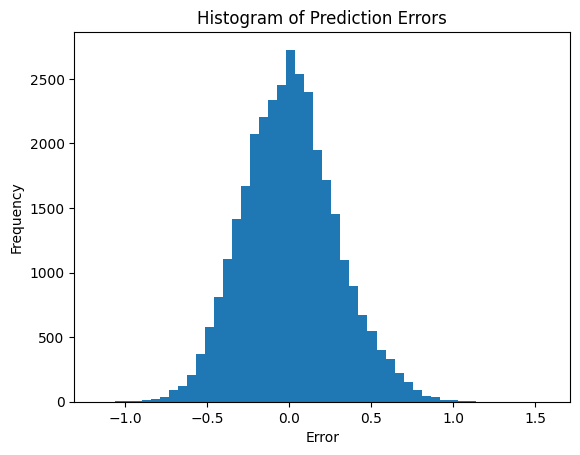

In [57]:
y_diff = y_true - y_pred
plt.hist(y_diff,bins = 50)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()